In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<font color='red'>**Changes in this version:**</font>



- These two lines in the dataset
```
self.images = os.listdir(image_dir)[int(number_of_samples*split_ratio):]
self.masks = os.listdir(mask_dir)[int(number_of_samples*split_ratio):]
```
Have been changed to:
```
self.images = self.images[int(number_of_samples*split_ratio):]
self.masks = self.images[int(number_of_samples*split_ratio):]
```

- The comment defining the mask output in the dataset, has been changed from
```
onehot_mask (torch.Tensor): One-hot encoded mask tensor for segmentation.
```
to
```
mask (torch.Tensor): Mask tensor for segmentation.
```

- `model` is transfered to `cpu` before saving the weights.

- There was a mistake in the previous update
```
self.masks = self.images[int(number_of_samples*split_ratio):]
```
has been changed to:
```
self.masks = self.masks[int(number_of_samples*split_ratio):]
```

<font color='red'>IMPORTANT</font>: The output of your model should be logits.

## Problem Definition

We are addressing a **semantic segmentation problem**, specifically focusing on **teeth caries CT scans**. The dataset contains **teeth scans** along with their corresponding **segmentation masks**. The task involves segmenting the CT scan images to accurately identify regions affected by caries.

The objective is to develop a model that can effectively segment the images into the desired classes representing carious and non-carious regions. The challenge lies in optimizing the model's performance while managing memory constraints during training.

### Requirements:
- The model must be implemented using **`torch`** and **`torchvision`** only (no other deep learning libraries are allowed for the model architecture).
- The main class for the model must be named <font color='red'>**`Model`**</font>, and participants <font color='red'>**must not change this name**</font>.
- Do not change the init function inside the `Model` class.
- The size of your model must not exceed 70 MB.
- Instantiating your model must not require any parameters.


## Dataset

### Downloading the Teeth Dataset

First the dataset need to be downloaded.

In [ ]:
!pip install datasets tqdm -q
from huggingface_hub import login
from datasets import load_dataset
from huggingface_hub import snapshot_download
import os
import sys
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00


In [ ]:
dataset_id="RayanAi/Main_teeth_dataset"
# Set the local directory where you want to store the dataset
local_dataset_dir = "./Main_teeth_dataset"  # You can change this path to your desired location

# Create the directory if it doesn't exist
os.makedirs(local_dataset_dir, exist_ok=True)

# Suppress the output by redirecting it to os.devnull
with open(os.devnull, 'w') as fnull:
    # Save the original stdout
    original_stdout = sys.stdout
    try:
        # Redirect stdout to devnull to suppress output
        sys.stdout = fnull
        # Download the dataset and store it locally
        snapshot_download(repo_id=dataset_id, local_dir=local_dataset_dir, repo_type="dataset")
    finally:
        # Restore the original stdout
        sys.stdout = original_stdout

# Print message when download is complete
print("Dataset downloaded completely.")

# Calculate and print the total size of the downloaded files
total_size = 0
for dirpath, dirnames, filenames in os.walk(local_dataset_dir):
    for f in filenames:
        fp = os.path.join(dirpath, f)
        total_size += os.path.getsize(fp)

# Convert size to MB and print
print(f"Total size of downloaded files: {total_size / (1024 * 1024):.2f} MB")

# Get the absolute path of the dataset directory and print it
dataset_abs_path = os.path.abspath(local_dataset_dir)
print(f"Dataset has been saved at: [{dataset_abs_path}]")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Main_teeth_dataset.zip:   0%|          | 0.00/90.2M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.42k [00:00<?, ?B/s]

Dataset downloaded completely.
Total size of downloaded files: 86.07 MB
Dataset has been saved at: [/content/Main_teeth_dataset]


In [ ]:
!unzip -q ./Main_teeth_dataset/Main_teeth_dataset.zip -d ./Main_teeth_dataset/

### Handling Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2
#Define the split ratio
split_ratio = 0.8

#Write a Dataset function called TeethSegmentationDataset


#Write a Dataset function called TeethSegmentationDataset
class TeethSegmentationDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, transform: A.Compose, dataset_type: str = 'Train', noisy_masks: list = None):
        """
        Args:
            image_dir (str): Directory path containing input images.
            mask_dir (str): Directory path containing corresponding segmentation masks.
            transform (callable): Optional transformation to be applied to both the image and the mask. Use A.Compose. Use ToTensorV2()
            dataset_type (str, optional): Type of dataset, e.g., 'Train' or 'Test'. Defaults to 'Train'.
            noisy_masks (list, optional): Provide a list of names for images you want to be excluded from dataset
        """
        # Initialize paths and transformation
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.dataset_type = dataset_type

        # List of all images and masks
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)
        # Filter out noisy masks if provided
        if noisy_masks:
            self.images = [img for img in self.images if img not in noisy_masks]
            self.masks = [mask for mask in self.masks if mask not in noisy_masks]
        number_of_samples = len(self.images)

        if dataset_type == 'Train':
            self.images = self.images[:int(number_of_samples*split_ratio)]
            self.masks = self.masks[:int(number_of_samples*split_ratio)]
        elif dataset_type == 'Test':
            self.images = self.images[int(number_of_samples*split_ratio):]
            self.masks = self.masks[int(number_of_samples*split_ratio):]



    def __len__(self) -> int:
        """
        Returns:
            int: The total number of image-mask pairs in the designated dataset split.
        """
        # Return the length of the dataset (number of images)
        return len(self.images)


    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            index (int): Index of the image-mask pair to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing the image and its corresponding one-hot encoded mask.
                - image (torch.Tensor): Transformed image tensor.
                - mask (torch.Tensor): Mask tensor for segmentation.
        """
        # Load the image and mask
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        # Load image and mask as grayscale
        image = np.array(Image.open(image_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L"))
        transformed = self.transform(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']
        binary_mask = mask.unsqueeze(2)>0
        binary_mask = binary_mask.permute(2, 0, 1).float()

        return image, binary_mask

In [ ]:
######################augmenters######################
#You may want to alter this part
augmenter = A.Compose([
    A.Normalize(mean=(0.485,), std=(0.229,), max_pixel_value=255.0),
    ToTensorV2(),
])

######################################################

######################################################
#Don't touch this part
test_augmenter = A.Compose([
    A.Normalize(mean=(0.485,), std=(0.229,), max_pixel_value=255.0),
    ToTensorV2(),
])
######################################################

train_dataset = TeethSegmentationDataset(
    image_dir="./Main_teeth_dataset/images",
    mask_dir="./Main_teeth_dataset/labels",
    transform=augmenter,
    dataset_type='Train',

)

test_dataset = TeethSegmentationDataset(
    image_dir= "./Main_teeth_dataset/images",
    mask_dir="./Main_teeth_dataset/labels",
    transform=test_augmenter,
    dataset_type='Test',

)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
from torch.utils.data import DataLoader
batch_size=8
num_workers=0 # Increase this if you have a powerfull cpu
dataloaders = {
  'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
  'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
}
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


# Segmentation model
In this part you should design a segmentation model. If you have defined any functions used to define your model, you should upload it along the model code.

Your model shouldn't take any inputs or produce outputs when instantiating.

<font color='red'>Important: You can only use functions availble in `torch` and `torchvision`.</font>

In [ ]:
import torch.nn as nn


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Add your code here


    #######DO NOT CHANGE THIS PART########
    def init(self):
        self.load_state_dict(torch.load('model.pth',weights_only=True))
    ######################################

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        This method defines the forward pass of the model.

        Args:
            x (tensor): The input tensor, in the shape of (batch_size,1,512,512).

        Returns:
            mask (tensor): The output tensor logits, in the shape of (batch_size,1,512,512).
        """
        # Add you code here
        return mask

In [ ]:
model = Model().to(device)

image = next(iter(dataloaders['train']))[0].to(device)
out = model(image)
print(image.shape)
print(out.shape)
assert image.shape == (batch_size, 1, 512, 512), "You shouldn't change the size of the image"
assert out.shape == (batch_size, 1, 512, 512), "The output of your model do not have correct dimensions"

## Dice Score

Here is the dice score function. You model is evaluated based on the score from this function

In [ ]:
def dice_score(pred: torch.Tensor, target_mask: torch.Tensor, epsilon: float = 1e-6) -> float:
    """
    Computes the Dice score between the predicted and target segmentation masks.

    Args:
        pred (torch.Tensor): The predicted mask tensor, with values in range [0, 1].
        target_one_target_maskhot (torch.Tensor): The ground truth mask.
        epsilon (float, optional): A small value to avoid division by zero. Defaults to 1e-6.

    Returns:
        float: The Dice score, a similarity metric between 0 and 1.
    """
    pred = pred>0
    pred_flat = pred.contiguous().view(pred.shape[0], pred.shape[1], -1)
    target_flat = target_mask.contiguous().view(target_mask.shape[0], target_mask.shape[1], -1)

    intersection = (pred_flat * target_flat).sum(dim=-1)
    union = pred_flat.sum(dim=-1) + target_flat.sum(dim=-1)

    dice = (2. * intersection + epsilon) / (union + epsilon)

    dice_mean = dice.mean(dim=1)

    return dice_mean.mean()



## Training

In [ ]:
#Define your optimizer and loss function
#You can either use predefined loss functions or define one your self

criterion =
optimizer =


In [ ]:
import matplotlib.pyplot as plt
def visualize_mask(inputs: torch.Tensor, masks: torch.Tensor, outputs: torch.Tensor):
    # Convert tensors to numpy for visualization
    sample_index = 0  # Index of the sample to visualize
    channel = 0
    print(f'Dice score is {dice_score(outputs[sample_index:sample_index+1,channel:channel+1],masks[sample_index:sample_index+1,channel:channel+1])}')

    inputs_np = inputs.cpu().numpy()
    masks_np = masks.cpu().numpy()
    outputs_np = outputs.detach().cpu().numpy()

    # Choose a sample to visualize

    # Plotting
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(inputs_np[sample_index].transpose(1, 2, 0), cmap='gray')  # Assuming inputs are in CxHxW format
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks_np[sample_index, channel], cmap='gray')  # Display the first channel of the mask
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(outputs_np[sample_index, channel]>0, cmap='gray')  # Display the first channel of the output
    plt.title("Model Output Mask")
    plt.axis('off')

    plt.show()

The `train_model` function implements a simple training loop that iterates over a specified number of epochs. In each iteration, the model is trained on the training set and then evaluated on the validation set using the Dice score as the performance metric. The function returns the model as it is at the final epoch.

In [ ]:
import torch
import time
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim


model = model.to(device)  # Move model to GPU if available

# Training function with visualization support
def train_model(
    model: nn.Module,
    dataloaders: dict[str, DataLoader],
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    num_epochs: int = 25
) -> nn.Module:
    """
    Trains the model over a specified number of epochs using the given data loaders,
    criterion (loss function), and optimizer.

    Args:
        model (nn.Module): The PyTorch model to be trained.
        dataloaders (dict[str, DataLoader]): A dictionary containing 'train' and 'test' data loaders.
        criterion (nn.Module): The loss function to be used for training.
        optimizer (torch.optim.Optimizer): The optimizer used to adjust model parameters.
        num_epochs (int, optional): Number of epochs for training. Defaults to 25.

    Returns:
        nn.Module: The trained model.
    """
    since = time.time()

    train_losses = []
    test_losses = []
    dice_scores_epoch = []

    for epoch in range(num_epochs):
        dice_scores = []
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data
            for inputs, masks in dataloaders[phase]:
                inputs = inputs.to(device)
                masks = masks.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    loss = criterion(outputs,masks)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    else:
                        dice_scores.append(dice_score(outputs, masks))

                # Statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                test_losses.append(epoch_loss)
                dice_scores_epoch.append(torch.tensor(dice_scores).mean().item())

                visualize_mask(inputs, masks, outputs)


            print(f'{phase} Loss: {epoch_loss:.4f}')
            if phase == 'test':
                print(f'Dice score: {torch.tensor(dice_scores).mean()}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # Plot the results
    epochs_range = range(num_epochs)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, test_losses, label="Test Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Test Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, dice_scores_epoch, label="Dice Score", color="green")
    plt.legend(loc="lower right")
    plt.title("Dice Score")

    plt.show()

    return model

# Train the model
model = train_model(model, dataloaders, criterion, optimizer)

In [ ]:
model_save_path = "model.pth"
torch.save(model.cpu().state_dict(), model_save_path)

\

---





---



In [ ]:
# model.py
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """(Convolution => BatchNorm => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with MaxPool then DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.down(x)

class Up(nn.Module):
    """Upscaling then DoubleConv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, in_channels // 2, kernel_size=1, bias=False)
            )
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Calculate padding
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])

        # Concatenate along the channels axis
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """Final Convolution to get desired output channels"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.inc = DoubleConv(1, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.up1 = Up(256, 128, bilinear=True)
        self.up2 = Up(128, 64, bilinear=True)
        self.up3 = Up(64, 32, bilinear=True)
        self.outc = OutConv(32, 1)

    #######DO NOT CHANGE THIS PART########
    def init(self):
        self.load_state_dict(torch.load('model.pth', map_location='cpu'), strict=False)
    ######################################

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 512, 512).

        Returns:
            torch.Tensor: Output logits tensor of shape (batch_size, 1, 512, 512).
        """
        x1 = self.inc(x)       # Shape: (batch_size, 32, 512, 512)
        x2 = self.down1(x1)    # Shape: (batch_size, 64, 256, 256)
        x3 = self.down2(x2)    # Shape: (batch_size, 128, 128, 128)
        x4 = self.down3(x3)    # Shape: (batch_size, 256, 64, 64)
        x = self.up1(x4, x3)   # Shape: (batch_size, 128, 128, 128)
        x = self.up2(x, x2)    # Shape: (batch_size, 64, 256, 256)
        x = self.up3(x, x1)    # Shape: (batch_size, 32, 512, 512)
        mask = self.outc(x)    # Shape: (batch_size, 1, 512, 512)
        return mask


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Train dataset size: 482
Test dataset size: 121


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
----------
Train Loss: 0.7801
Dice score for sample 0: 0.0131


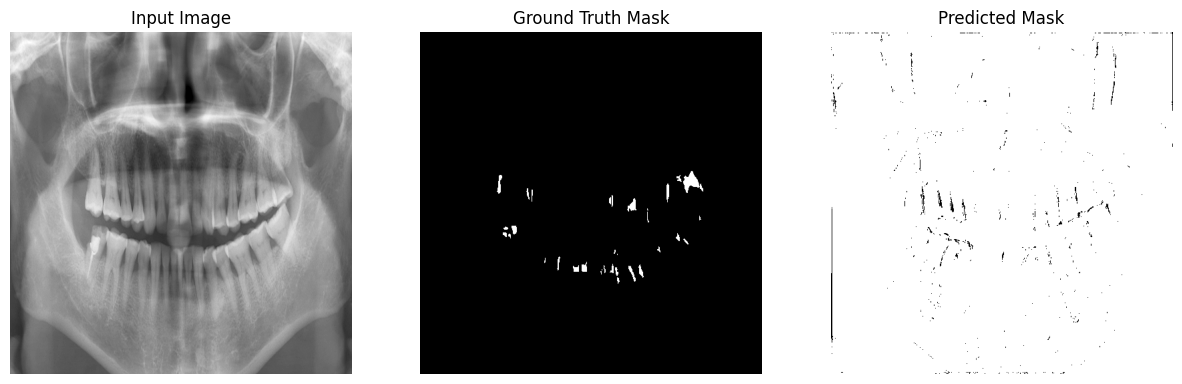

Test Loss: 0.7632 | Dice Score: 0.2074
Epoch 2/50
----------
Train Loss: 0.7799
Dice score for sample 0: 0.0135


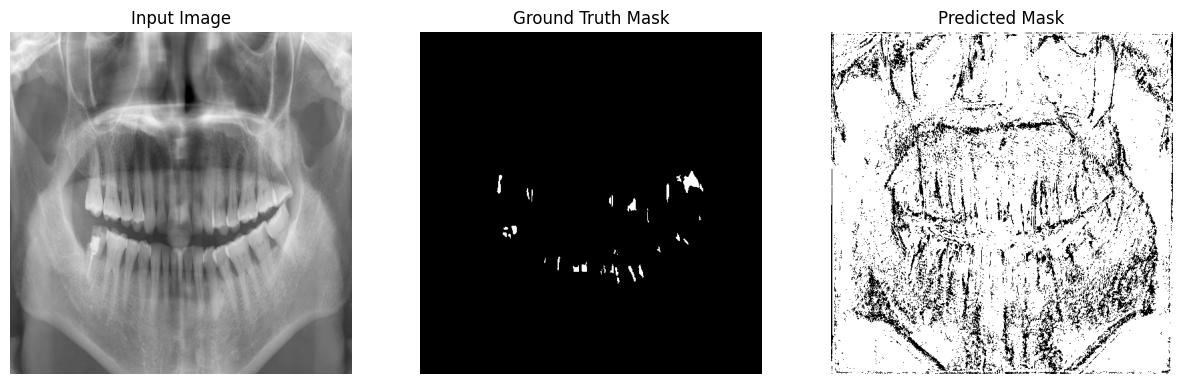

Test Loss: 0.7778 | Dice Score: 0.1958
Epoch 3/50
----------
Train Loss: 0.7801
Dice score for sample 0: 0.0138


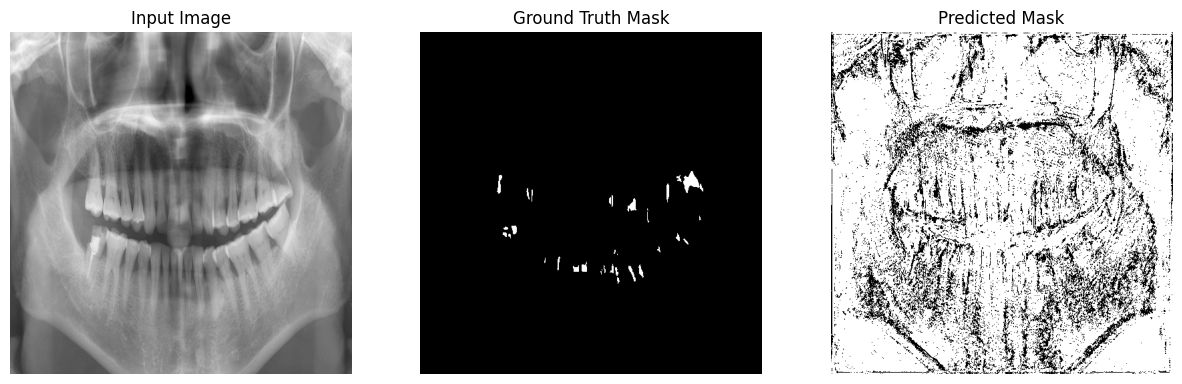

Test Loss: 0.7793 | Dice Score: 0.1930
Epoch 4/50
----------
Train Loss: 0.7799
Dice score for sample 0: 0.0136


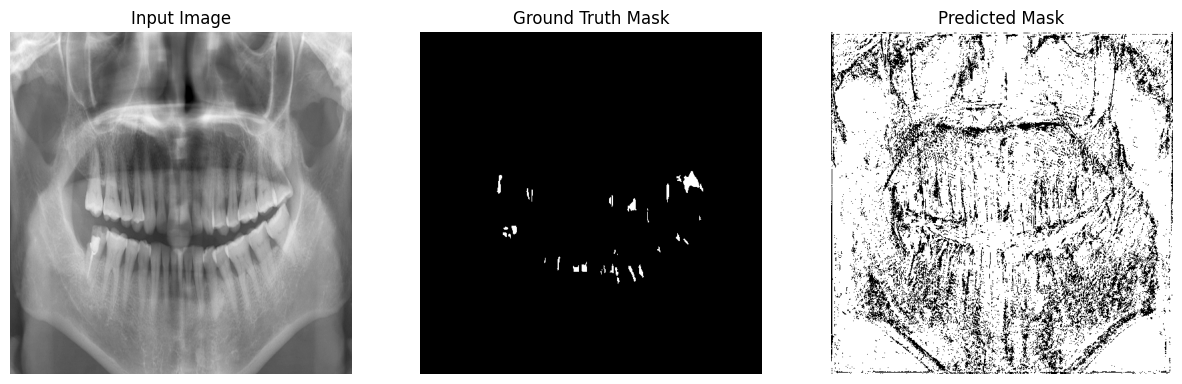

Test Loss: 0.7802 | Dice Score: 0.1926
Epoch 5/50
----------
Train Loss: 0.7809
Dice score for sample 0: 0.0138


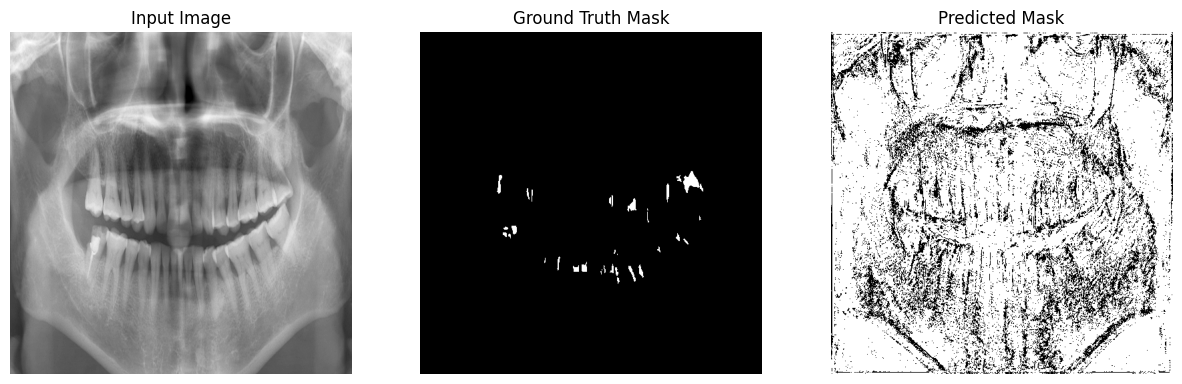

Test Loss: 0.7804 | Dice Score: 0.1926
Epoch 6/50
----------
Train Loss: 0.7801
Early stopping triggered
Model saved to model.pth with size 6.89 MB


In [ ]:
# train.py
import os
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt

from model import Model  # Ensure model.py is in the same directory

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the TeethSegmentationDataset
class TeethSegmentationDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, transform: A.Compose, dataset_type: str = 'Train', noisy_masks: list = None):
        """
        Args:
            image_dir (str): Directory path containing input images.
            mask_dir (str): Directory path containing corresponding segmentation masks.
            transform (callable): Transformation to be applied to both image and mask.
            dataset_type (str, optional): 'Train' or 'Test'. Defaults to 'Train'.
            noisy_masks (list, optional): List of mask filenames to exclude. Defaults to None.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.dataset_type = dataset_type

        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

        if noisy_masks:
            self.images = [img for img in self.images if img not in noisy_masks]
            self.masks = [mask for mask in self.masks if mask not in noisy_masks]

        assert len(self.images) == len(self.masks), "Number of images and masks do not match!"

        number_of_samples = len(self.images)
        split_ratio = 0.8  # 80% training, 20% testing

        if dataset_type == 'Train':
            self.images = self.images[:int(number_of_samples * split_ratio)]
            self.masks = self.masks[:int(number_of_samples * split_ratio)]
        elif dataset_type == 'Test':
            self.images = self.images[int(number_of_samples * split_ratio):]
            self.masks = self.masks[int(number_of_samples * split_ratio):]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # Load image and mask
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        image = np.array(Image.open(image_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L"))

        # Apply transformations
        transformed = self.transform(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']

        # Binarize the mask and ensure it has a channel dimension
        binary_mask = (mask > 0).float()  # Shape: (1, 512, 512) if mask has channel

        # Verify the shape of binary_mask
        if binary_mask.dim() == 2:
            binary_mask = binary_mask.unsqueeze(0)  # Add channel dimension

        return image, binary_mask

# Define augmentations
augmenter = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485,), std=(0.229,), max_pixel_value=255.0),
    ToTensorV2(),
])

test_augmenter = A.Compose([
    A.Normalize(mean=(0.485,), std=(0.229,), max_pixel_value=255.0),
    ToTensorV2(),
])

# Initialize datasets and dataloaders
train_dataset = TeethSegmentationDataset(
    image_dir="./Main_teeth_dataset/images",
    mask_dir="./Main_teeth_dataset/labels",
    transform=augmenter,
    dataset_type='Train',
)

test_dataset = TeethSegmentationDataset(
    image_dir="./Main_teeth_dataset/images",
    mask_dir="./Main_teeth_dataset/labels",
    transform=test_augmenter,
    dataset_type='Test',
)

batch_size = 16  # Increased batch size based on Colab's high-performance GPU
num_workers = 2  # Adjusted based on system recommendation

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Define Dice Score Function
def dice_score(pred: torch.Tensor, target_mask: torch.Tensor, epsilon: float = 1e-6) -> float:
    """
    Computes the Dice score between the predicted and target segmentation masks.

    Args:
        pred (torch.Tensor): The predicted mask tensor, with values in range [0, 1].
        target_mask (torch.Tensor): The ground truth mask.
        epsilon (float, optional): A small value to avoid division by zero. Defaults to 1e-6.

    Returns:
        float: The Dice score, a similarity metric between 0 and 1.
    """
    pred = torch.sigmoid(pred) > 0.5  # Threshold logits to get binary predictions
    pred_flat = pred.view(pred.size(0), -1).float()
    target_flat = target_mask.view(target_mask.size(0), -1)

    intersection = (pred_flat * target_flat).sum(dim=1)
    union = pred_flat.sum(dim=1) + target_flat.sum(dim=1)

    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice.mean().item()

# Define Loss Function and Optimizer
model = Model()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# Visualization Function
def visualize_mask(inputs: torch.Tensor, masks: torch.Tensor, outputs: torch.Tensor):
    """
    Visualizes the input image, ground truth mask, and model's output mask.

    Args:
        inputs (torch.Tensor): Input images tensor.
        masks (torch.Tensor): Ground truth masks tensor.
        outputs (torch.Tensor): Model's output logits tensor.
    """
    sample_index = 0  # Index of the sample to visualize
    channel = 0  # Since masks are single-channel

    dice = dice_score(outputs[sample_index:sample_index+1], masks[sample_index:sample_index+1])
    print(f'Dice score for sample {sample_index}: {dice:.4f}')

    inputs_np = inputs.cpu().numpy()
    masks_np = masks.cpu().numpy()
    outputs_np = torch.sigmoid(outputs).detach().cpu().numpy()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(inputs_np[sample_index][0], cmap='gray')  # Grayscale image
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks_np[sample_index][0], cmap='gray')  # Ground truth mask
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(outputs_np[sample_index][0] > 0.5, cmap='gray')  # Predicted mask
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

# Training Function with Scheduler and Early Stopping
def train_model(model: nn.Module, dataloaders: dict, criterion: nn.Module, optimizer: optim.Optimizer, scheduler, num_epochs: int = 50, patience: int = 5) -> nn.Module:
    """
    Trains the model with learning rate scheduling and early stopping.

    Args:
        model (nn.Module): The PyTorch model to be trained.
        dataloaders (dict): Dictionary containing 'train' and 'test' DataLoaders.
        criterion (nn.Module): Loss function.
        optimizer (optim.Optimizer): Optimizer.
        scheduler: Learning rate scheduler.
        num_epochs (int, optional): Number of training epochs. Defaults to 50.
        patience (int, optional): Number of epochs with no improvement after which training will be stopped. Defaults to 5.

    Returns:
        nn.Module: The trained model.
    """
    since = time.time()

    train_losses = []
    test_losses = []
    dice_scores_epoch = []

    best_dice = 0.0
    epochs_no_improve = 0

    model = model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch +1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_dice = 0.0

            # Iterate over data
            for inputs, masks in dataloaders[phase]:
                inputs = inputs.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    else:
                        dice = dice_score(outputs, masks)
                        running_dice += dice * inputs.size(0)

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                epoch_dice = running_dice / len(dataloaders[phase].dataset)
                test_losses.append(epoch_loss)
                dice_scores_epoch.append(epoch_dice)

                # Update the scheduler based on validation Dice score
                scheduler.step(epoch_dice)

                # Early Stopping Check
                if epoch_dice > best_dice:
                    best_dice = epoch_dice
                    epochs_no_improve = 0
                    # Save the best model
                    torch.save(model.state_dict(), 'best_model.pth')
                else:
                    epochs_no_improve += 1

                # Check if early stopping should be triggered
                if epochs_no_improve >= patience:
                    print("Early stopping triggered")
                    return model

                # Visualize predictions
                visualize_mask(inputs, masks, outputs)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}', end='')
            if phase == 'test':
                print(f' | Dice Score: {epoch_dice:.4f}')
            else:
                print()

    time_elapsed = time.time() - since
    print(f'Training complete in {int(time_elapsed // 60)}m {int(time_elapsed % 60)}s')

    # Plot Loss and Dice Score
    epochs_range = range(1, epoch + 2)  # Adjusted to reflect actual epochs run
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, dice_scores_epoch, label='Dice Score', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Dice Score Over Epochs')
    plt.legend()

    plt.show()

    return model

# Initialize and Train the Model with Scheduler and Early Stopping
model = Model()
model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50, patience=5)

# Save the trained model
model_save_path = "model.pth"
torch.save(model.cpu().state_dict(), model_save_path)
model_size = os.path.getsize(model_save_path) / (1024 * 1024)  # Size in MB
print(f"Model saved to {model_save_path} with size {model_size:.2f} MB")


In [ ]:
# train.py

import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from sklearn.model_selection import train_test_split
import cv2
import zipfile  # برای فشرده‌سازی فایل‌ها
import matplotlib.pyplot as plt
import time

from model import Model

# پیکربندی دستگاه
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True  # بهینه‌سازی cudNN

# تعریف کلاس Dataset
class TeethSegmentationDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def denoise_mask(self, mask):
        mask = mask.astype(np.uint8)
        kernel = np.ones((3,3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
        return mask

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        # بارگذاری تصویر به صورت grayscale (۱ کانال)
        image = np.array(Image.open(image_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L"))

        # حذف نویز از ماسک
        mask = self.denoise_mask(mask)

        # باینری‌سازی ماسک
        mask = (mask > 128).astype(np.float32)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # افزودن بعد کانال به ماسک در صورت نیاز
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)

        # افزودن بعد کانال به تصویر
        if image.dim() == 2:
            image = image.unsqueeze(0)

        return image.float(), mask.float()

# تنظیمات Data Augmentation با تکنیک‌های پیشرفته
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.ElasticTransform(alpha=120, sigma=120*0.05, p=0.5),
    A.GridDistortion(p=0.5),
    A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=1),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.GaussianBlur(p=0.5),
    A.MotionBlur(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),  # نرمال‌سازی تصاویر grayscale
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

# تعریف و بارگذاری Dataset و DataLoader
def get_dataloaders(image_dir, mask_dir, batch_size=32, num_workers=8):
    full_dataset = TeethSegmentationDataset(
        image_dir=image_dir,
        mask_dir=mask_dir,
        transform=None  # تنظیم transform بعداً
    )

    # تقسیم Dataset به Training و Validation
    train_idx, val_idx = train_test_split(
        list(range(len(full_dataset))),
        test_size=0.2,
        random_state=42
    )

    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(full_dataset, val_idx)

    # اختصاص دادن transform ها
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = test_transform

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader

# مسیر داده‌ها (به‌روزرسانی کنید)
image_dir = "./Main_teeth_dataset/images"
mask_dir = "./Main_teeth_dataset/labels"

# دریافت DataLoaders
train_loader, val_loader = get_dataloaders(image_dir, mask_dir, batch_size=32, num_workers=8)

print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

# تعریف و بارگذاری مدل
model = Model().to(device)

# تعریف Optimizer و Scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# تعریف توابع Loss
# Lovász Loss (باید lovasz_losses.py را داشته باشید)
# اطمینان حاصل کنید که lovasz_losses.py در مسیر پروژه است
from lovasz_losses import lovasz_hinge  # اطمینان حاصل کنید که lovasz_losses.py موجود است

# Dice Loss
def dice_loss_fn(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3))
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + smooth))
    return loss.mean()

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        BCE_loss = self.bce_loss(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss

# Dice Score Function
def dice_score_fn(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    pred = pred.contiguous()
    target = target.contiguous()
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2,3))
    score = ((2. * intersection + smooth) / (pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + smooth))
    return score.mean().item()

# تعریف توابع Loss ترکیبی
def combined_loss(pred, target):
    lovasz = lovasz_hinge(pred, target, per_image=True)
    dice = dice_loss_fn(pred, target)
    focal = FocalLoss()(pred, target)
    return lovasz + dice + focal

# تعریف تابع آموزش مدل با Mixed Precision
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=100):
    best_loss = np.inf
    best_model_wts = None
    early_stopping_patience = 15
    epochs_no_improve = 0

    scaler = torch.cuda.amp.GradScaler()  # برای mixed precision

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # فاز آموزش
        model.train()
        train_loss = 0.0
        train_dice = 0.0

        for batch_idx, (inputs, masks) in enumerate(train_loader):
            inputs = inputs.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = combined_loss(outputs, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * inputs.size(0)
            train_dice += dice_score_fn(outputs, masks) * inputs.size(0)

            if (batch_idx + 1) % 50 == 0:
                print(f'Train Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f} - Dice: {dice_score_fn(outputs, masks):.4f}')

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_dice = train_dice / len(train_loader.dataset)
        print(f'Train Loss: {epoch_train_loss:.4f} | Train Dice: {epoch_train_dice:.4f}')

        # فاز اعتبارسنجی
        model.eval()
        val_loss = 0.0
        val_dice = 0.0

        with torch.no_grad():
            for batch_idx, (inputs, masks) in enumerate(val_loader):
                inputs = inputs.to(device, non_blocking=True)
                masks = masks.to(device, non_blocking=True)

                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = combined_loss(outputs, masks)

                val_loss += loss.item() * inputs.size(0)
                val_dice += dice_score_fn(outputs, masks) * inputs.size(0)

                if (batch_idx + 1) % 50 == 0:
                    print(f'Val Batch {batch_idx+1}/{len(val_loader)} - Loss: {loss.item():.4f} - Dice: {dice_score_fn(outputs, masks):.4f}')

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_dice = val_dice / len(val_loader.dataset)
        print(f'Validation Loss: {epoch_val_loss:.4f} | Validation Dice: {epoch_val_dice:.4f}')

        # به‌روزرسانی Scheduler
        scheduler.step(epoch_val_loss)

        # بررسی بهبود
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
            torch.save(best_model_wts, 'model.pth')
            print("Best model saved.")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print("Early stopping triggered!")
                break

        print()

    # بارگذاری بهترین وزن‌ها
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return model

# اجرای تابع آموزش
if __name__ == "__main__":
    # حذف فایل‌های قدیمی در صورت وجود
    if os.path.exists('model.pth'):
        os.remove('model.pth')

    if os.path.exists('submission.zip'):
        os.remove('submission.zip')

    # آموزش مدل
    start_time = time.time()
    trained_model = train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=100)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

    # ذخیره مدل نهایی
    torch.save(trained_model.state_dict(), 'model.pth')
    model_size = os.path.getsize('model.pth') / (1024 * 1024)  # حجم به مگابایت
    print(f"Model saved as model.pth with size {model_size:.2f} MB")

    # فشرده‌سازی فایل‌های مورد نیاز
    def create_zip():
        with zipfile.ZipFile('submission.zip', 'w') as zipf:
            zipf.write('model.py')
            zipf.write('model.pth')
            zipf.write('lovasz_losses.py')  # اطمینان حاصل کنید که این فایل موجود است

    create_zip()
    print("Files zipped into submission.zip")


Train dataset size: 482
Validation dataset size: 121
First conv layer in_channels: 1
Epoch 1/100
----------


<ipython-input-19-3b16197ddb68>:194: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # برای mixed precision
<ipython-input-19-3b16197ddb68>:211: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


x0 shape: torch.Size([32, 64, 128, 128])
x1 shape: torch.Size([32, 256, 128, 128])
x2 shape: torch.Size([32, 512, 64, 64])
x3 shape: torch.Size([32, 1024, 32, 32])
x4 shape: torch.Size([32, 2048, 16, 16])
d4 after up4: torch.Size([32, 1024, 32, 32])
d4 after concat with x3: torch.Size([32, 2048, 32, 32])
d4 after conv4: torch.Size([32, 1024, 32, 32])
d3 after up3: torch.Size([32, 512, 64, 64])
d3 after concat with x2: torch.Size([32, 1024, 64, 64])
d3 after conv3: torch.Size([32, 512, 64, 64])
d2 after up2: torch.Size([32, 256, 128, 128])
d2 after concat with x1: torch.Size([32, 512, 128, 128])
d2 after conv2: torch.Size([32, 256, 128, 128])
d1 after up1: torch.Size([32, 64, 256, 256])
x0_up shape: torch.Size([32, 64, 256, 256])
d1 after concat with x0_up: torch.Size([32, 128, 256, 256])
d1 after conv1: torch.Size([32, 64, 256, 256])
out after final_conv: torch.Size([32, 1, 256, 256])
out after interpolate: torch.Size([32, 1, 512, 512])
x0 shape: torch.Size([32, 64, 128, 128])
x1 shape

<ipython-input-19-3b16197ddb68>:239: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Streaming output truncated to the last 5000 lines.
d4 after concat with x3: torch.Size([32, 2048, 32, 32])
d4 after conv4: torch.Size([32, 1024, 32, 32])
d3 after up3: torch.Size([32, 512, 64, 64])
d3 after concat with x2: torch.Size([32, 1024, 64, 64])
d3 after conv3: torch.Size([32, 512, 64, 64])
d2 after up2: torch.Size([32, 256, 128, 128])
d2 after concat with x1: torch.Size([32, 512, 128, 128])
d2 after conv2: torch.Size([32, 256, 128, 128])
d1 after up1: torch.Size([32, 64, 256, 256])
x0_up shape: torch.Size([32, 64, 256, 256])
d1 after concat with x0_up: torch.Size([32, 128, 256, 256])
d1 after conv1: torch.Size([32, 64, 256, 256])
out after final_conv: torch.Size([32, 1, 256, 256])
out after interpolate: torch.Size([32, 1, 512, 512])
x0 shape: torch.Size([32, 64, 128, 128])
x1 shape: torch.Size([32, 256, 128, 128])
x2 shape: torch.Size([32, 512, 64, 64])
x3 shape: torch.Size([32, 1024, 32, 32])
x4 shape: torch.Size([32, 2048, 16, 16])
d4 after up4: torch.Size([32, 1024, 32, 32]

In [ ]:
# quantize.py

import torch
import torch.quantization
from model import Model
from torch.utils.data import DataLoader, Subset
import numpy as np
import os
import warnings

# تعریف تابع Dice Score
def dice_score_fn(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    pred = pred.contiguous()
    target = target.contiguous()
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2,3))
    score = ((2. * intersection + smooth) / (pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + smooth))
    return score.mean().item()

# بارگذاری مدل آموزش دیده
model = Model()
model_path = 'model.pth'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"مدل آموزش دیده در مسیر {model_path} پیدا نشد.")
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()

# تبدیل مدل به CPU
model.cpu()

# تعریف یک تابع برای نادیده گرفتن کوانتیزیشن در ConvTranspose2d
def disable_quantization(module):
    if isinstance(module, torch.nn.ConvTranspose2d):
        module.qconfig = None

# اعمال تابع به تمامی لایه‌های مدل
model.apply(disable_quantization)

# مشخص کردن Quantization Config
# از 'fbgemm' برای CPU های x86 استفاده می‌کنیم
model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
print(f'Quantization Config: {model.qconfig}')

# آماده‌سازی مدل برای کوانتیزیشن
torch.quantization.prepare(model, inplace=True)

# کالیبراسیون مدل با استفاده از داده‌های آموزشی
# فرض کنید train_dataset و DataLoader آن قبلاً تعریف شده‌اند
from train import train_loader  # اطمینان حاصل کنید که train_loader در train.py قابل دسترسی است

calibration_subset = Subset(train_loader.dataset, indices=range(100))  # انتخاب 100 نمونه برای کالیبراسیون
calibration_loader = DataLoader(calibration_subset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

print("شروع کالیبراسیون مدل...")
with torch.no_grad():
    for batch_idx, (inputs, _) in enumerate(calibration_loader):
        inputs = inputs.to('cpu')
        outputs = model(inputs)
        if batch_idx % 10 == 0:
            print(f"کالیبراسیون: {batch_idx * 8}/{len(calibration_loader.dataset)} نمونه")

print("کالیبراسیون کامل شد.")

# اعمال کوانتیزیشن
torch.quantization.convert(model, inplace=True)

# ذخیره مدل کوانتیزه شده
quantized_model_path = 'model_quantized.pth'
torch.save(model.state_dict(), quantized_model_path)
print(f"مدل کوانتیزه شده در مسیر {quantized_model_path} ذخیره شد.")

# بررسی حجم مدل کوانتیزه شده
model_size = os.path.getsize(quantized_model_path) / (1024 * 1024)  # حجم به مگابایت
print(f"حجم مدل کوانتیزه شده: {model_size:.2f} MB")

# اطمینان از اینکه حجم مدل کمتر از 70MB است
if model_size > 70:
    warnings.warn(f"حجم مدل کوانتیزه شده ({model_size:.2f} MB) از حد مجاز 70MB بیشتر است.")
else:
    print("حجم مدل کوانتیزه شده در حد مجاز قرار دارد.")


First conv layer in_channels: 1


<ipython-input-22-97650273d4ca>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='cpu'))


Quantization Config: QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})


ModuleNotFoundError: No module named 'train'

In [ ]:
!wget https://raw.githubusercontent.com/bermanmaxim/LovaszSoftmax/master/pytorch/lovasz_losses.py


--2024-10-29 10:46:10--  https://raw.githubusercontent.com/bermanmaxim/LovaszSoftmax/master/pytorch/lovasz_losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8352 (8.2K) [text/plain]
Saving to: ‘lovasz_losses.py’

lovasz_losses.py    100%[===================>]   8.16K  --.-KB/s    in 0s      

2024-10-29 10:46:11 (77.4 MB/s) - ‘lovasz_losses.py’ saved [8352/8352]



In [ ]:
!cp /content/drive/MyDrive/ML/Rayan/Q2/submission/submission10.zip /content

In [ ]:
!unzip /content/submission10.zip

Archive:  /content/submission10.zip
 extracting: model.py                
 extracting: model.pth               
replace lovasz_losses.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# prune_model.py

import torch
import torch.nn.utils.prune as prune
from model import Model
import os

# بارگذاری مدل آموزش دیده
model = Model()
model_path = 'model.pth'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"مدل آموزش دیده در مسیر {model_path} پیدا نشد.")
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()

# اعمال هرس کردن به لایه‌های Conv2d
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.4)  # حذف 40% وزن‌ها
        prune.remove(module, 'weight')

# ذخیره مدل هرس شده
pruned_model_path = 'model_pruned.pth'
torch.save(model.state_dict(), pruned_model_path)
print(f"مدل هرس شده در مسیر {pruned_model_path} ذخیره شد.")

# بررسی حجم مدل هرس شده
model_size = os.path.getsize(pruned_model_path) / (1024 * 1024)  # حجم به مگابایت
print(f"حجم مدل هرس شده: {model_size:.2f} MB")


First conv layer in_channels: 1


<ipython-input-16-9bad51305b38>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='cpu'))


مدل هرس شده در مسیر model_pruned.pth ذخیره شد.
حجم مدل هرس شده: 282.32 MB


In [ ]:
!rm model.py model.pth

rm: cannot remove 'model.py': No such file or directory
rm: cannot remove 'model.pth': No such file or directory


In [ ]:
!ls

Main_teeth_dataset  model.py  resnet50.pth  sample_data


In [ ]:
!ls /content/Main_teeth_dataset

images	labels	Main_teeth_dataset.zip


In [ ]:
!rm -rf __pycache__

In [ ]:
!mv /content/submission.zip /content/submission10.zip

In [ ]:
!touch model.py

In [ ]:
# download_weights.py

import torch
from torchvision import models

def download_resnet50_weights():
    # بارگذاری مدل ResNet50 با وزن‌های پیش‌تربیت‌شده
    model = models.resnet50(pretrained=True)
    # ذخیره state_dict به صورت محلی
    torch.save(model.state_dict(), 'resnet50.pth')
    print("وزن‌های مدل ResNet50 در فایل resnet50.pth ذخیره شدند.")

if __name__ == "__main__":
    download_resnet50_weights()


In [ ]:
import zipfile
import os

def zip_multiple_files(input_paths, output_zip_path, compression_level=5):
    # Ensure compression level is within 1-9
    compression_level = max(1, min(compression_level, 1))

    # Create a zip file with the specified compression level
    compression = zipfile.ZIP_DEFLATED

    # Create the zip file
    with zipfile.ZipFile(output_zip_path, 'w', compression) as zipf:
        for input_path in input_paths:
            # Check if the file or directory exists
            if not os.path.exists(input_path):
                print(f"{input_path} does not exist.")
                continue

            # If it's a directory, recursively add files
            if os.path.isdir(input_path):
                for root, dirs, files in os.walk(input_path):
                    for file in files:
                        file_full_path = os.path.join(root, file)
                        zipf.write(file_full_path,
                                   os.path.relpath(file_full_path,
                                                   os.path.join(input_path, '..')))
            # If it's a single file, add it to the zip file
            else:
                zipf.write(input_path, os.path.basename(input_path))

    print(f"Successfully zipped files to {output_zip_path} with compression level {compression_level}")

# Example usage:
input_paths = ['/content/model.py', '/content/model.pth']  # List of files or directories to zip
output_zip_path = '/content/submission9.zip'  # Path to save the output zip file
compression_level = 5  # Compression level from 1 (fastest) to 9 (most compressed)
zip_multiple_files(input_paths, output_zip_path, compression_level)


Successfully zipped files to /content/submission9.zip with compression level 1


In [ ]:
!cp /content/submission10.zip /content/drive/MyDrive/ML/Rayan/Q2/submission

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
